# Lensing Background Galaxies by Foreground Halos

#### Spencer Everett, SLAC 7/29/2015

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import os,sys
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import cmath
import cPickle as pickle
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
%matplotlib inline

In [3]:
# Pangloss:
PANGLOSS_DIR = os.path.expandvars("$PANGLOSS_DIR")
sys.path.append(PANGLOSS_DIR)
import pangloss

Import the convergence and shear maps:

In [4]:
K = pangloss.Kappamap(PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.kappa',FITS=False)

In [5]:
S = pangloss.Shearmap([PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.gamma_1',PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.gamma_2'],FITS=False)

Import the foreground galaxy catalog for the (0,0,0,0) field:

In [6]:
config = pangloss.Configuration(PANGLOSS_DIR+'/example/example.config')
F = pangloss.ForegroundCatalog(PANGLOSS_DIR+'/data/GGL_los_8_0_0_0_0_N_4096_ang_4_Guo_galaxies_on_plane_27_to_63.images.txt',config)

In [ ]:
F.__dict__

Generate a background galaxy catalog in a small part of the same field with 10 sources per square arcminute:

In [14]:
#d = [1.85,1.15,-1.85,-1.15] #40x40 arcmin
d = [1.65,1.35,-1.65,-1.35]
B = pangloss.BackgroundCatalog(N=10.0,sigma_e=0.01,domain=d,field=[0,0,0,0])
B.lens_by_map(K,S)
B.galaxy_count

3239

In [15]:
B.drill_lightcones(foreground=F,save=False)

0   0.0 %
323   9.97221364619 %
646   19.9444272924 %
969   29.9166409386 %
1292   39.8888545847 %
1615   49.8610682309 %
1938   59.8332818771 %
2261   69.8054955233 %
2584   79.7777091695 %
2907   89.7499228157 %
3230   99.7221364619 %


In [16]:
galaxy_counts = [B.lightcones[i].galaxy_count for i in range(len(B.lightcones))]
mean_galaxies = np.mean(galaxy_counts)
std_galaxies = np.std(galaxy_counts)
print mean_galaxies,'+/-',std_galaxies

953.751157765 +/- 66.9249865382


In [17]:
B.lens_by_halos()

0   0.0 %
323   9.97221364619 %
646   19.9444272924 %
969   29.9166409386 %
1292   39.8888545847 %
1615   49.8610682309 %
1938   59.8332818771 %
2261   69.8054955233 %
2584   79.7777091695 %
2907   89.7499228157 %
3230   99.7221364619 %
average CPU time per background galaxy:  0.0821804090502 +/- 0.814827312826


In [18]:
k_diff = abs((B.galaxies['kappa_halo']-B.galaxies['kappa'])/B.galaxies['kappa'])*100.0
k_diff_mean = np.mean(k_diff)
k_diff_std = np.std(k_diff)
print 'k_diff mean: ',k_diff_mean,'%'
print 'k_diff std: ',k_diff_std,'%'
print

g_diff = abs((B.galaxies['g_halo']-B.galaxies['g'])/B.galaxies['g'])*100.0
g_diff_mean = np.mean(g_diff)
g_diff_std = np.std(g_diff)
print 'g_diff mean: ',g_diff_mean,'%'
print 'g_diff std: ',g_diff_std,'%'
print

mod_diff = abs((B.galaxies['eMod_halo']-B.galaxies['eMod'])/B.galaxies['eMod'])*100.0
mod_diff_mean = np.mean(mod_diff)
mod_diff_std = np.std(mod_diff)
print 'mod_diff mean: ',mod_diff_mean,'%'
print 'mod_diff std: ',mod_diff_std,'%'
print

phi_diff = abs((B.galaxies['ePhi_halo']-B.galaxies['ePhi'])/B.galaxies['ePhi'])*100.0
phi_diff_mean = np.mean(phi_diff)
phi_diff_std = np.std(phi_diff)
print 'phi_diff mean: ',phi_diff_mean,'%'
print 'phi_diff std: ',phi_diff_std,'%'
print

print 'mean kappa: ',np.mean(B.galaxies['kappa'])
print 'mean kappa_halo: ',np.mean(B.galaxies['kappa_halo'])
print

print 'mean g: ',np.mean(B.galaxies['g'])
print 'mean g_halo: ',np.mean(B.galaxies['g_halo'])
print

print np.max(B.galaxies['g'])
print np.max(B.galaxies['g_halo'])

k_diff mean:  1379.31286128 %
k_diff std:  12716.958407 %

g_diff mean:  153.17370265 %
g_diff std:  135.334292382 %

mod_diff mean:  75.3967056217 %
mod_diff std:  226.256566879 %

phi_diff mean:  236.854215587 %
phi_diff std:  1601.24761405 %

mean kappa:  -0.00264911232123
mean kappa_halo:  0.0414332696955

mean g:  (-0.00332096654753-0.0068614883199j)
mean g_halo:  (1.86903147017e-05+0.000626618168551j)

(0.163896911835-0.127693893497j)
(0.211007895618-0.230273212826j)


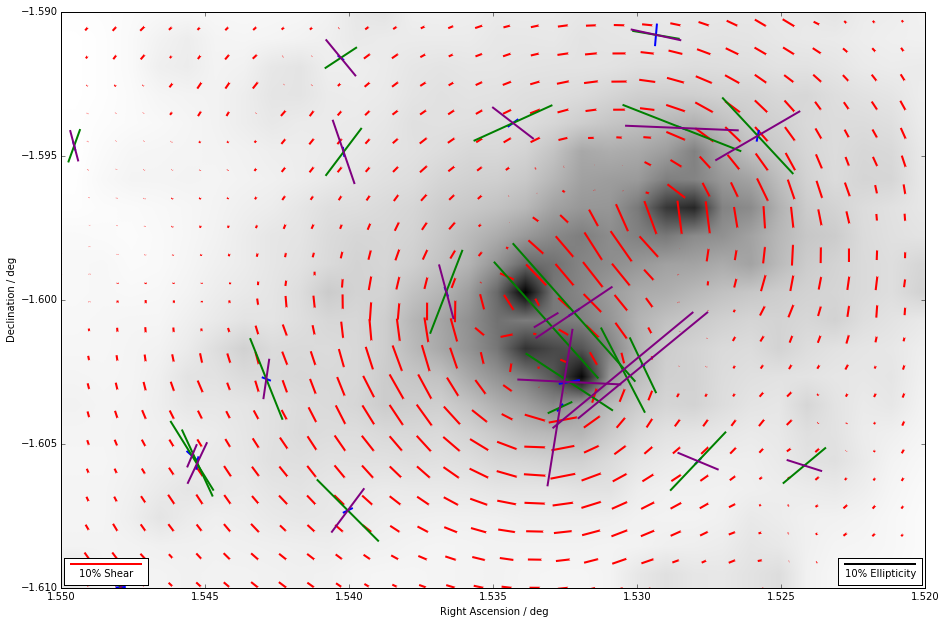

In [19]:
K.plot(fig_size=15,subplot=[1.55,1.52,-1.61,-1.59])
S.plot()
#B.galaxies['ePhi_halo'] *= -1.0
B.plot(lensed='all',graph='stick')

In [ ]:
gg_map = B.calculate_corr(corr_type='gg',lensed='map')
gg_halo = B.calculate_corr(corr_type='gg',lensed='halo')

In [ ]:
pangloss.plotting.plot_corr(gg_map,corr_type='gg',corr_comp='plus',lensed='map',color='blue',max_sep=5,galaxy_count=B.galaxy_count)
pangloss.plotting.plot_corr(gg_halo,corr_type='gg',corr_comp='plus',lensed='halo',color='green',max_sep=5)

In [ ]:
pangloss.plotting.plot_corr(gg_map,corr_type='gg',corr_comp='plus',lensed='map',color='blue',max_sep=5galaxy_count=B.galaxy_count)
pangloss.plotting.plot_corr(gg_halo,corr_type='gg',corr_comp='plus',lensed='halo',color='green',max_sep=5)
pangloss.plotting.plot_corr(gg_map,corr_type='gg',corr_comp='cross',lensed='map',color='blue',max_sep=5)
pangloss.plotting.plot_corr(gg_halo,corr_type='gg',corr_comp='cross',lensed='halo',color='green',max_sep=5)